<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S7-Assignment/EVA_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
%matplotlib inline
import random # for random image index


from tqdm import tqdm # for beautiful model training updates
from model import Network

Seed and Cuda

In [3]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


### 1. Loading Data



In [4]:
## downloading training data, using this to calculate mean and standard deviation 

train_mean_std_dev = datasets.CIFAR10(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.ToTensor()# converts to tesnor
    )

Files already downloaded and verified


In [5]:
train_mean_std_dev.data.shape  ## looking at the shape of the data

(50000, 32, 32, 3)

In [6]:
# Getting Mean and Standard Deviation of CIFAR 10 dataset
def get_mean_std_dev(dataset):
  '''
  reference : https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data
  '''

  data = dataset.data / 255 # data is numpy array

  mean = data.mean(axis = (0,1,2)) 
  std = data.std(axis = (0,1,2))
  # print(f"Mean : {mean}   STD: {std}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]
  return tuple(mean), tuple(std)



mean, std_dev = get_mean_std_dev(train_mean_std_dev)
print(f"Mean : {mean}   STD: {std_dev}") #Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]


Mean : (0.4913996786152028, 0.4821584083946074, 0.4465309144454644)   STD: (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


In [7]:
!pip install -U albumentations

import albumentations as A

from albumentations.pytorch.transforms import ToTensorV2

def apply_transforms(mean,std_dev):
    train_transforms = A.Compose([
        A.HorizontalFlip(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.2),
        A.CoarseDropout(
            max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=tuple((x * 255.0 for x in mean)), p=0.2,
        ),
        A.ToGray(p=0.15),
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    test_transforms = A.Compose([
        A.Normalize(mean=mean, std=std_dev, always_apply=True),
        ToTensorV2(),
    ])

    return lambda img: train_transforms(image=np.array(img))["image"], lambda img: test_transforms(image=np.array(img))["image"]


train_transforms, test_transforms = apply_transforms(mean,std_dev)

In [8]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(mean, std_dev)])

batch_size = 128
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Visualizing Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck  ship  bird  frog  bird  bird truck   car  deer  frog  deer  bird   car truck horse  frog   car   car  deer   cat  frog plane plane plane  ship   cat horse  frog  ship  deer horse   dog   car truck horse  bird truck   cat  frog plane   cat   dog   car truck  bird  ship  bird truck horse truck  bird  frog  bird  frog  ship horse  ship truck  ship  frog truck   dog horse   car  ship plane  frog   car   dog truck horse   car truck   car   car   dog truck horse horse  bird  deer   cat   dog   cat  ship   car  deer  deer   cat   dog   dog  deer  ship  ship truck  deer  frog horse   dog truck  ship horse   dog   dog  ship  ship  frog  bird  deer  ship truck  frog truck   cat   car  ship  frog   car  deer plane horse  frog  ship truck   dog plane  bird truck


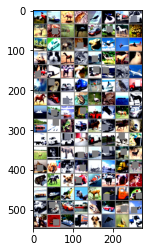

In [9]:
import matplotlib.pyplot as plt # for visualizing images
import numpy as np
import torchvision

def imshow(img):
  '''
  function to show an image
  '''
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### 2. Network
Defining CNN

In [10]:
import torch
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method

drop_out_value = 0.1

class Network(nn.Module):
    def __init__(self):
      super(Network,self).__init__() # extending super class method

      # Input block
      self.convblock_input= nn.Sequential(
        nn.Conv2d(3,32,3,padding=1), # In- 3x32x32, Out- 32x32x32, RF- 3x3, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
      
      # CONV BLOCK 1
      self.convblock1 = nn.Sequential(
        nn.Conv2d(32,32,3,padding=1), # In- 32x32x32, Out- 32x32x32, RF- 5x5, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        ,
        nn.Conv2d(32,32,3,padding=1), # In- 32x32x32, Out- 32x32x32, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )

      # TRANSITION BLOCK 1
      # STRIDED CONVOLUTION LAYER
      self.transitionblock1 = nn.Sequential(
        nn.Conv2d(32,32,3,stride=2,padding=1), # In- 32x32x32, Out- 32x16x16, RF- 9x9, Jump_in -1, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
      
      # CONV BLOCK 2
      # Depthwise Separable Convolution Layer
      self.convblock2 = nn.Sequential(
        nn.Conv2d(32,32,3,padding=1,groups=32),# In- 32x16x16, Out- 32x16x16, RF- 13x13, Jump_in -2, Jump_out -2
        nn.Conv2d(32,32,1,padding=0), # In-32x16x16 , Out- 32x16x16, RF- 13x13, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        ,
        nn.Conv2d(32,32,3,padding=1), # In-32x16x16 , Out-32x16x16 , RF- 17x17, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
      
      # TRANSITION BLOCK 2
      # STRIDED CONVOLUTION LAYER
      self.transitionblock2 = nn.Sequential(
        nn.Conv2d(32,32,3,stride=2,padding=1), # In- 32x16x16, Out-32x8x8 , RF- 21x21, Jump_in -2, Jump_out -4
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
        
      
      # CONV BLOCK 3
      # Dilated Convolution Layer
      self.convblock3 = nn.Sequential(
        nn.Conv2d(32,32,3,padding=1,dilation=2),# In- 32x8x8, Out-32x6x6 , RF- 29x29, Jump_in -4, Jump_out -4
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        ,
        nn.Conv2d(32,32,3,padding=1), # In-32x6x6 , Out- 32x6x6, RF- 37x37, Jump_in -4, Jump_out -4
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )
      
      # TRANSITION BLOCK 3
      # STRIDED CONVOLUTION LAYER
      self.transitionblock3 = nn.Sequential(
        nn.Conv2d(32,32,3,stride=2,padding=1), # In-32x6x6 , Out-32x3x3 , RF- 45x45, Jump_in -4, Jump_out -8
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        )   

      # CONV BLOCK 4
      # Depthwise Separable Convolution Layer
      self.convblock4 = nn.Sequential(
        nn.Conv2d(32,32,3,padding=1), # In- 32x3x3, Out-32x3x3 , RF- 61x61, Jump_in -8, Jump_out -8
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout(drop_out_value)
        ,
        nn.Conv2d(32,32,3,padding=1,groups=32), # In-32x3x3 , Out-32x3x3 , RF- 77x77, Jump_in -8, Jump_out -8
        nn.Conv2d(32,10,1,padding=0) # In- 32x3x3, Out-10x3x3 , RF- 77x77, Jump_in -8, Jump_out -8
        # , 
        # nn.ReLU(),
        # nn.BatchNorm2d(10),
        # nn.Dropout(drop_out_value)
        )
      
      # Output BLOCK 
      # GAP Layer
      self.gap = nn.AvgPool2d(3) # In- 10x3x3, Out-10x1x1 , RF- 77x77, Jump_in -8, Jump_out -8


    def forward(self, x):
      x = self.convblock_input(x)
      x = self.convblock1(x)
      x = self.transitionblock1(x)
      x = self.convblock2(x)
      x = self.transitionblock2(x)
      x = self.convblock3(x)
      x = self.transitionblock3(x)
      x = self.convblock4(x)
      x = self.gap(x)

      x = x.view(-1, 10)

      return F.log_softmax(x, dim=1)

#### Model Params
Checking the model summary and number of parameters


In [11]:
device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Network().to(device)
# print(model)

# !pip install torchsummary
from torchsummary import summary # for model summary and params
summary(model, input_size=(3, 32, 32))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 16, 16]           9,248
             ReLU-14           [-1

### 3. Training and Testing

*   includes test and train functions
*   includes loop function, where test can happen after each epoch is trained

In [12]:
import torch.optim as optim # for optimizer


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training 
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = criterion(y_preds,labels) # capturing loss

    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)


    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_accuracy.append(100*correct/processed)

In [14]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = criterion(outputs,labels).item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))

In [15]:
EPOCHS = 20
# EPOCHS = 2

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)



EPOCH: 0


Loss=2.063260555267334 Batch_id=390 Accuracy=16.14: 100%|██████████| 391/391 [00:36<00:00, 10.66it/s]



Test set: Average loss: 0.0002, Accuracy: 2410/10000 (24.10%)

EPOCH: 1


Loss=1.793959617614746 Batch_id=390 Accuracy=26.91: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.0002, Accuracy: 2872/10000 (28.72%)

EPOCH: 2


Loss=1.6651866436004639 Batch_id=390 Accuracy=33.62: 100%|██████████| 391/391 [00:36<00:00, 10.74it/s]



Test set: Average loss: 0.0002, Accuracy: 3940/10000 (39.40%)

EPOCH: 3


Loss=1.5634078979492188 Batch_id=390 Accuracy=38.90: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]



Test set: Average loss: 0.0002, Accuracy: 4473/10000 (44.73%)

EPOCH: 4


Loss=1.509131669998169 Batch_id=390 Accuracy=43.80: 100%|██████████| 391/391 [00:36<00:00, 10.66it/s]



Test set: Average loss: 0.0002, Accuracy: 5044/10000 (50.44%)

EPOCH: 5


Loss=1.3789705038070679 Batch_id=390 Accuracy=48.47: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]



Test set: Average loss: 0.0001, Accuracy: 5555/10000 (55.55%)

EPOCH: 6


Loss=1.1604359149932861 Batch_id=390 Accuracy=51.84: 100%|██████████| 391/391 [00:36<00:00, 10.74it/s]



Test set: Average loss: 0.0001, Accuracy: 5750/10000 (57.50%)

EPOCH: 7


Loss=1.2521942853927612 Batch_id=390 Accuracy=54.68: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.0001, Accuracy: 6111/10000 (61.11%)

EPOCH: 8


Loss=1.3868145942687988 Batch_id=390 Accuracy=57.05: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.0001, Accuracy: 6350/10000 (63.50%)

EPOCH: 9


Loss=1.103663444519043 Batch_id=390 Accuracy=59.24: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]



Test set: Average loss: 0.0001, Accuracy: 6549/10000 (65.49%)

EPOCH: 10


Loss=1.3100295066833496 Batch_id=390 Accuracy=61.07: 100%|██████████| 391/391 [00:36<00:00, 10.71it/s]



Test set: Average loss: 0.0001, Accuracy: 6771/10000 (67.71%)

EPOCH: 11


Loss=0.885241687297821 Batch_id=390 Accuracy=62.54: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]



Test set: Average loss: 0.0001, Accuracy: 6865/10000 (68.65%)

EPOCH: 12


Loss=1.240031361579895 Batch_id=390 Accuracy=63.76: 100%|██████████| 391/391 [00:36<00:00, 10.66it/s]



Test set: Average loss: 0.0001, Accuracy: 7048/10000 (70.48%)

EPOCH: 13


Loss=0.825356662273407 Batch_id=390 Accuracy=64.99: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]



Test set: Average loss: 0.0001, Accuracy: 7051/10000 (70.51%)

EPOCH: 14


Loss=0.9569212198257446 Batch_id=390 Accuracy=65.99: 100%|██████████| 391/391 [00:36<00:00, 10.72it/s]



Test set: Average loss: 0.0001, Accuracy: 7232/10000 (72.32%)

EPOCH: 15


Loss=0.9249483346939087 Batch_id=390 Accuracy=67.01: 100%|██████████| 391/391 [00:32<00:00, 11.89it/s]



Test set: Average loss: 0.0001, Accuracy: 7262/10000 (72.62%)

EPOCH: 16


Loss=0.8401675224304199 Batch_id=390 Accuracy=67.79: 100%|██████████| 391/391 [00:36<00:00, 10.63it/s]



Test set: Average loss: 0.0001, Accuracy: 7290/10000 (72.90%)

EPOCH: 17


Loss=0.9104496836662292 Batch_id=390 Accuracy=68.80: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]



Test set: Average loss: 0.0001, Accuracy: 7477/10000 (74.77%)

EPOCH: 18


Loss=0.8102456331253052 Batch_id=390 Accuracy=69.40: 100%|██████████| 391/391 [00:36<00:00, 10.68it/s]



Test set: Average loss: 0.0001, Accuracy: 7486/10000 (74.86%)

EPOCH: 19


Loss=0.9291302561759949 Batch_id=390 Accuracy=70.00: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s]



Test set: Average loss: 0.0001, Accuracy: 7529/10000 (75.29%)



### 4. Checking results

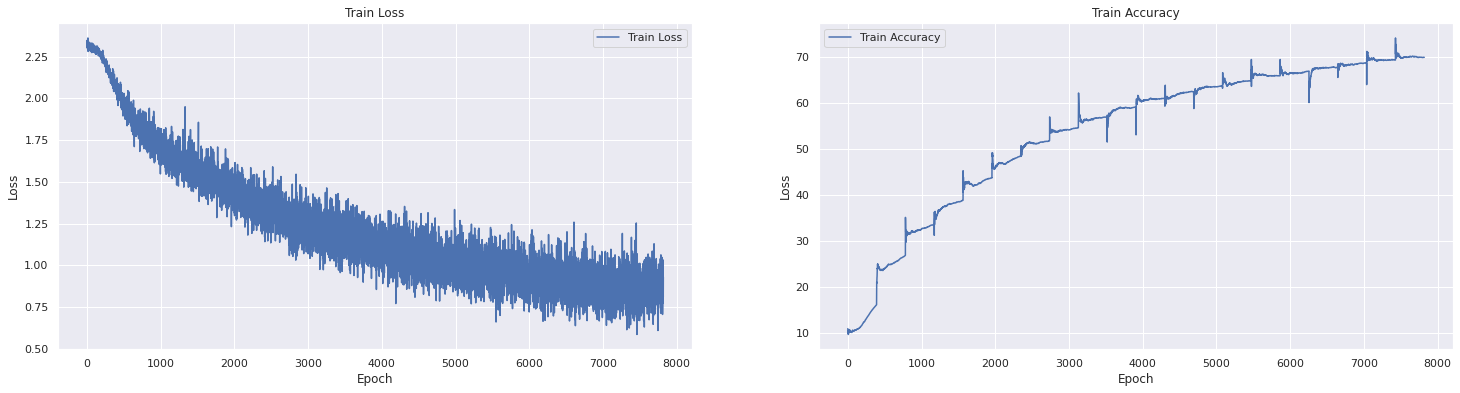

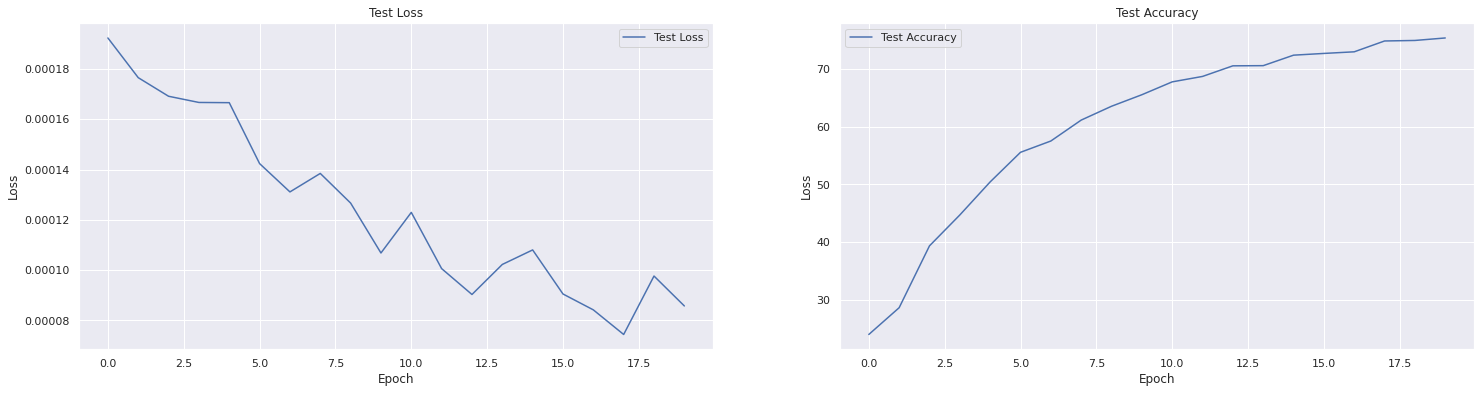

In [16]:
import seaborn as sns

def plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)

    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(train_losses), 'b', label="Train Loss")
    
    # Label the plot.
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(train_accuracy), 'b', label="Train Accuracy")
    
    # Label the plot.
    ax2.set_title("Train Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()
    
    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Test Loss")
    
    # Label the plot.
    ax1.set_title("Test Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(test_accuracy), 'b', label="Test Accuracy")
    
    # Label the plot.
    ax2.set_title("Test Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()

plot_metrics(train_accuracy, train_losses, test_accuracy, test_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   frog   car  frog   cat   car
Predicted:   frog truck  deer   cat   car


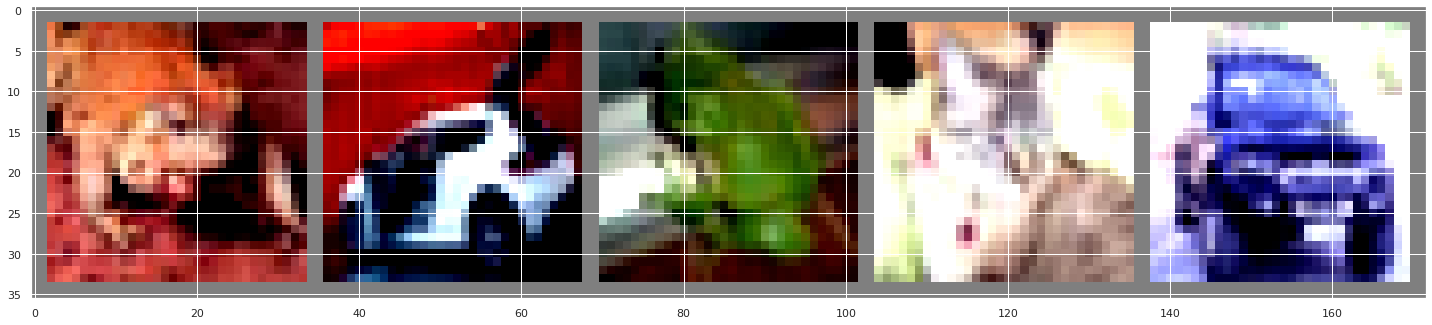

In [17]:
def show_predicted_actual(model, device, dataset, classes):
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# print images
	imshow(torchvision.utils.make_grid(images[img_list]))
	print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in img_list))

	images = images.to(device)
	outputs = model(images)

	_, predicted = torch.max(outputs, 1)
	print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in img_list))
 

show_predicted_actual(model, device, testloader, classes)


In [18]:
def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
      
evaluate_classwise_accuracy(model, device, classes, testloader)


Accuracy of plane : 48 %
Accuracy of   car : 96 %
Accuracy of  bird : 75 %
Accuracy of   cat : 35 %
Accuracy of  deer : 81 %
Accuracy of   dog : 54 %
Accuracy of  frog : 86 %
Accuracy of horse : 76 %
Accuracy of  ship : 96 %
Accuracy of truck : 84 %
